<a href="https://colab.research.google.com/github/ananyanivarthi/Paddy/blob/main/Final_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **STAGE1**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Upload kaggle.json
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file

# Create the .kaggle directory
import os
os.makedirs('/root/.kaggle', exist_ok=True)

# Move the kaggle.json file to the .kaggle directory
import shutil
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Set permissions for the kaggle.json file
!chmod 600 /root/.kaggle/kaggle.json
# Download the dataset
!kaggle datasets download -d imbikramsaha/paddy-doctor

# Unzip the dataset
!unzip -q paddy-doctor.zip -d paddy_doctor


In [ ]:
import os
import shutil

# Define source directories
dataset1_dir = '/content/drive/MyDrive/PADDYYYY'
dataset2_dir = '/content/paddy_doctor'

# Define destination directory
merged_dataset_dir = '/content/merged_dataset'

# Create the destination directory if it doesn't exist
if not os.path.exists(merged_dataset_dir):
    os.makedirs(merged_dataset_dir)

# Supported image file extensions
supported_extensions = ('.jpg', '.jpeg', '.png')

# Function to copy files to the merged directory
def copy_files(src_dir, dest_dir):
    for root, dirs, files in os.walk(src_dir):
        for file in files:
            if file.lower().endswith(supported_extensions):
                src_file_path = os.path.join(root, file)
                # Preserve directory structure
                rel_path = os.path.relpath(root, src_dir)
                dest_sub_dir = os.path.join(dest_dir, rel_path)
                if not os.path.exists(dest_sub_dir):
                    os.makedirs(dest_sub_dir)
                dest_file_path = os.path.join(dest_sub_dir, file)
                shutil.copy(src_file_path, dest_file_path)

# Copy files from both datasets to the merged directory, preserving structure
copy_files(dataset1_dir, merged_dataset_dir)
copy_files(dataset2_dir, merged_dataset_dir)

print("Files have been copied successfully.")


In [ ]:
pip install timm

In [ ]:
import torch
from torchvision import transforms
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.model_selection import train_test_split
import os
import shutil
from timm import create_model

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
def preprocess_image(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
        image_transformed = transform(image).unsqueeze(0).to(device)
        return image, image_transformed
    except UnidentifiedImageError:
        print(f"Cannot identify image file {image_path}")
        return None, None

# Load pre-trained models for the ensemble
models = {
    'efficientnet': create_model('efficientnet_b0', pretrained=True).to(device),
    'seresnext': create_model('seresnext50_32x4d', pretrained=True).to(device),
    'deit': create_model('deit_small_patch16_224', pretrained=True).to(device),
    'mobilenetv3': create_model('mobilenetv3_large_100', pretrained=True).to(device),
    'resnet': create_model('resnet18', pretrained=True).to(device),
}

# Remove the final classification layers to get feature vectors
for name, model in models.items():
    model.head = torch.nn.Identity() if hasattr(model, 'head') else torch.nn.Sequential(*list(model.children())[:-1])
    model.eval()

def extract_features(image, model):
    with torch.no_grad():
        features = model(image).flatten().cpu().numpy()
    return features

# Calculate cosine similarity
def calculate_similarity(feature1, feature2):
    return 1 - cosine(feature1, feature2)

# Threshold for similarity
similarity_threshold = 0.75

# Define supported image file extensions
supported_extensions = ('.jpg', '.jpeg', '.png')

# Split the dataset into train, validation, and test sets
def split_dataset(dataset_dir, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2):
    image_paths = [os.path.join(root, file) for root, _, files in os.walk(dataset_dir) for file in files if file.lower().endswith(supported_extensions)]
    train_paths, test_paths = train_test_split(image_paths, test_size=test_ratio, random_state=42)
    train_paths, val_paths = train_test_split(train_paths, test_size=val_ratio/(train_ratio+val_ratio), random_state=42)
    return train_paths, val_paths, test_paths

# Test the ensemble model on a specific image using the test set
def test_ensemble_on_image(input_image_path, test_image_paths):
    input_image, input_image_transformed = preprocess_image(input_image_path)
    if input_image_transformed is None:
        return False

    votes = []

    for test_image_path in test_image_paths:
        _, test_image_transformed = preprocess_image(test_image_path)
        if test_image_transformed is None:
            continue

        for name, model in models.items():
            input_features = extract_features(input_image_transformed, model)
            test_features = extract_features(test_image_transformed, model)

            similarity = calculate_similarity(input_features, test_features)
            if similarity >= similarity_threshold:
                votes.append(1)  # Similar image found
                break
        else:
            votes.append(0)  # No similar image found

    # Majority voting
    return votes.count(1) > votes.count(0)

# Example usage
merged_dataset_dir = '/content/merged_dataset'  # Replace with your actual dataset directory path
train_paths, val_paths, test_paths = split_dataset(merged_dataset_dir)

input_image_path = '/content/land.jpg'
is_cultivable = test_ensemble_on_image(input_image_path, test_paths)

# Get terminal width
columns, _ = shutil.get_terminal_size()

# Center the result text
result_text = "The image is of cultivable land." if is_cultivable else "The image is not of cultivable land."
print(result_text.center(columns))

# Display the image
image, _ = preprocess_image(input_image_path)
if image:
    plt.imshow(image)
    plt.axis('off')
    plt.show()


# **STAGE 2**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define the path to your dataset
data_dir = '/content/drive/MyDrive/PADDYYYY'

# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.ToTensor(),           # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
])

In [ ]:
import os
from PIL import Image
from tqdm import tqdm

# Function to filter out non-image files based on extension
def is_image_file(filename):
    image_extensions = ['.jpeg', '.jpg', '.png']
    for ext in image_extensions:
        if filename.endswith(ext):
            return True
    return False

# Path to your dataset directory
dataset_dir = '/content/drive/MyDrive/PADDYYYY-20240814T083859Z-001/PADDYYYY'

# List to store valid image paths
image_paths = []

# Iterate through each file in the directory
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if is_image_file(file):
            image_paths.append(os.path.join(root, file))

# Process each image file
for img_path in tqdm(image_paths):
    try:
        img = Image.open(img_path)
        # Perform operations as needed (e.g., resizing, cropping, etc.)
        # Example: img = img.resize((256, 256))
        img.close()  # Close the image file
    except (IOError, OSError) as e:
        print(f"Error processing {img_path}: {e}")

print(f"Processed {len(image_paths)} image files.")


In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_to_idx = {}  # Dictionary to map class names to indices

        self._load_data()

    def _load_data(self):
        class_idx = 0
        for class_name in os.listdir(self.data_dir):
            class_dir = os.path.join(self.data_dir, class_name)
            if os.path.isdir(class_dir):
                self.class_to_idx[class_name] = class_idx
                for root, _, files in os.walk(class_dir):
                    for image_name in files:
                        image_path = os.path.join(root, image_name)
                        try:
                            # Attempt to open the image file
                            img = Image.open(image_path)
                            img.verify()  # Verify if the file is a valid image
                            self.images.append(image_path)
                            self.labels.append(class_idx)
                        except (IOError, SyntaxError) as e:
                            # Print an error message or handle the exception as needed
                            print(f'Skipping {image_path}: {e}')
                class_idx += 1

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

    def get_class_name(self, idx):
        for name, index in self.class_to_idx.items():
            if index == idx:
                return name
        return None

# Example usage:
data_dir = '/content/drive/MyDrive/PADDYYYY-20240814T083859Z-001/PADDYYYY'
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

custom_dataset = CustomDataset(data_dir, transform=transform)
data_loader = DataLoader(custom_dataset, batch_size=32, shuffle=True)

# Now you can use custom_dataset.class_to_idx to get class indices or names


In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Function to filter out non-image files based on extension
def is_image_file(filename):
    image_extensions = ['.jpeg', '.jpg', '.png']
    return any(filename.endswith(ext) for ext in image_extensions)

class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_to_idx = {'PADDY IMAGES': 0, 'OTHER CROPS': 1}  # Dictionary to map class names to indices

        self._load_data()

    def _load_data(self):
        for class_name in self.class_to_idx.keys():
            class_dir = os.path.join(self.data_dir, class_name)
            if os.path.isdir(class_dir):
                for root, _, files in os.walk(class_dir):
                    for image_name in files:
                        image_path = os.path.join(root, image_name)
                        if is_image_file(image_name):
                            try:
                                img = Image.open(image_path)
                                img.verify()  # Verify if the file is a valid image
                                self.images.append(image_path)
                                self.labels.append(self.class_to_idx[class_name])
                            except (IOError, SyntaxError) as e:
                                print(f'Skipping {image_path}: {e}')

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

    def get_class_name(self, idx):
        for name, index in self.class_to_idx.items():
            if index == idx:
                return name
        return None

# Example usage:
data_dir = '/content/drive/MyDrive/PADDYYYY-20240814T083859Z-001/PADDYYYY'
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

custom_dataset = CustomDataset(data_dir, transform=transform)
data_loader = DataLoader(custom_dataset, batch_size=32, shuffle=True)

# Print class to index mapping
print(custom_dataset.class_to_idx)  # Should print {'PADDY IMAGES': 0, 'OTHER CROPS': 1}

# Print a few samples to verify
for idx in range(10):  # Print first 10 samples
    print(f"Image: {custom_dataset.images[idx]}, Label: {custom_dataset.get_class_name(custom_dataset.labels[idx])}")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from timm import create_model

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset
dataset = datasets.ImageFolder(root='/content/drive/MyDrive/PADDYYYY-20240814T083859Z-001/PADDYYYY', transform=transform)

# Define split sizes
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

models = {
    'efficientnet': create_model('efficientnet_b0', pretrained=True).to(device),
    'seresnext': create_model('seresnext50_32x4d', pretrained=True).to(device),
    'deit': create_model('deit_small_patch16_224', pretrained=True).to(device),
    'mobilenetv3': create_model('mobilenetv3_large_100', pretrained=True).to(device),
    'resnet': create_model('resnet18', pretrained=True).to(device),
}

# Modify the final layer of each model
for name, model in models.items():
    if hasattr(model, 'classifier'):
        model.classifier = nn.Linear(model.classifier.in_features, 2).to(device)
    elif hasattr(model, 'fc'):
        model.fc = nn.Linear(model.fc.in_features, 2).to(device)
    elif hasattr(model, 'head'):
        model.head = nn.Linear(model.head.in_features, 2).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizers = {name: optim.Adam(model.parameters(), lr=0.001) for name, model in models.items()}

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for model in models.values():
        model.train()

    running_loss = {name: 0.0 for name in models}

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        for name, model in models.items():
            optimizer = optimizers[name]
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss[name] += loss.item() * inputs.size(0)

    for name in models:
        epoch_loss = running_loss[name] / len(train_dataset)
        print(f'Epoch [{epoch+1}/{num_epochs}], Model {name}, Loss: {epoch_loss:.4f}')

# Save the trained models
for name, model in models.items():
    torch.save(model.state_dict(), f'{name}_model.pth')

# Ensemble Evaluation on Validation and Test Sets
def evaluate_ensemble(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs_ensemble = torch.zeros(inputs.size(0), 2).to(device)

            for model in models.values():
                model.eval()
                outputs_ensemble += model(inputs)

            _, predicted = torch.max(outputs_ensemble, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

val_accuracy = evaluate_ensemble(val_loader)
print(f'Validation Accuracy: {val_accuracy:.2f}%')

test_accuracy = evaluate_ensemble(test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from timm import create_model

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the models in the ensemble
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

models = {
    'efficientnet': create_model('efficientnet_b0', pretrained=False).to(device),
    'seresnext': create_model('seresnext50_32x4d', pretrained=False).to(device),
    'deit': create_model('deit_small_patch16_224', pretrained=False).to(device),
    'mobilenetv3': create_model('mobilenetv3_large_100', pretrained=False).to(device),
    'resnet': create_model('resnet18', pretrained=False).to(device),
}

# Modify and load model weights
num_classes = 2
for name, model in models.items():
    if hasattr(model, 'classifier'):
        model.classifier = nn.Linear(model.classifier.in_features, num_classes).to(device)
    elif hasattr(model, 'fc'):
        model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)
    elif hasattr(model, 'head'):
        model.head = nn.Linear(model.head.in_features, num_classes).to(device)
    model.load_state_dict(torch.load(f'{name}_model.pth'))
    model.eval()

# Function to classify the image using the ensemble
def classify_image(image_path):
    # Open the image file
    image = Image.open(image_path).convert('RGB')
    # Apply transformations
    transformed_image = transform(image).unsqueeze(0).to(device)

    # Ensemble inference
    outputs_ensemble = torch.zeros(1, num_classes).to(device)
    with torch.no_grad():
        for model in models.values():
            outputs = model(transformed_image)
            outputs_ensemble += outputs

    _, predicted = torch.max(outputs_ensemble, 1)

    # Map predicted class to label
    class_names = ['non-paddy', 'paddy']  # Adjust these class names as needed
    result = class_names[predicted.item()]

    return image, result

# Path to the image you want to classify
image_path = '/content/sunflowercrop.jpg'  # Replace with the path to your image

# Classify the image and get the result
image, result = classify_image(image_path)

# Display the image and result
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title(f'The crop in the image is: {result}')
plt.axis('off')  # Hide axes
plt.show()



In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from timm import create_model

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the models in the ensemble
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

models = {
    'efficientnet': create_model('efficientnet_b0', pretrained=False).to(device),
    'seresnext': create_model('seresnext50_32x4d', pretrained=False).to(device),
    'deit': create_model('deit_small_patch16_224', pretrained=False).to(device),
    'mobilenetv3': create_model('mobilenetv3_large_100', pretrained=False).to(device),
    'resnet': create_model('resnet18', pretrained=False).to(device),
}

# Modify and load model weights
num_classes = 2
for name, model in models.items():
    if hasattr(model, 'classifier'):
        model.classifier = nn.Linear(model.classifier.in_features, num_classes).to(device)
    elif hasattr(model, 'fc'):
        model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)
    elif hasattr(model, 'head'):
        model.head = nn.Linear(model.head.in_features, num_classes).to(device)
    model.load_state_dict(torch.load(f'{name}_model.pth'))
    model.eval()

# Function to classify the image using the ensemble
def classify_image(image_path):
    # Open the image file
    image = Image.open(image_path).convert('RGB')
    # Apply transformations
    transformed_image = transform(image).unsqueeze(0).to(device)

    # Ensemble inference
    outputs_ensemble = torch.zeros(1, num_classes).to(device)
    with torch.no_grad():
        for model in models.values():
            outputs = model(transformed_image)
            outputs_ensemble += outputs

    _, predicted = torch.max(outputs_ensemble, 1)

    # Map predicted class to label
    class_names = ['non-paddy', 'paddy']  # Adjust these class names as needed
    result = class_names[predicted.item()]

    return image, result

# Path to the image you want to classify
image_path = '/content/paddy1.png'  # Replace with the path to your image

# Classify the image and get the result
image, result = classify_image(image_path)

# Display the image and result
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title(f'The crop in the image is: {result}')
plt.axis('off')  # Hide axes
plt.show()



In [ ]:
import torch.nn as nn
from timm import create_model
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Load the trained models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
models = {
    'efficientnet': create_model('efficientnet_b0', pretrained=False).to(device),
    'seresnext': create_model('seresnext50_32x4d', pretrained=False).to(device),
    'deit': create_model('deit_small_patch16_224', pretrained=False).to(device),
    'mobilenetv3': create_model('mobilenetv3_large_100', pretrained=False).to(device),
    'resnet': models.resnet18(pretrained=False).to(device),
}

# Modify output layers and load weights
for name, model in models.items():
    # Check and modify the classification layer accordingly
    if hasattr(model, 'classifier'):
        model.classifier = nn.Linear(model.classifier.in_features, 2).to(device)
    elif hasattr(model, 'head'):
        model.head = nn.Linear(model.head.in_features, 2).to(device)
    elif hasattr(model, 'fc'):
        model.fc = nn.Linear(model.fc.in_features, 2).to(device)
    else:
        raise AttributeError(f"The model {name} does not have a recognized classification layer.")

    # Load the state dict for each model
    model.load_state_dict(torch.load(f'/content/{name}_model.pth', map_location=device))
    model.eval()

# Get all predictions and labels from the ensemble
all_preds = []
all_labels = []
probs = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Aggregate predictions from all models
        outputs = sum(model(inputs) for model in models.values()) / len(models)

        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())

# Compute and display confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Paddy', 'Other Crops'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Print classification report
print(classification_report(all_labels, all_preds, target_names=['Paddy', 'Other Crops']))

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(all_labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# **STAGE 3**

In [ ]:
!pip install timm

In [ ]:
# Download the dataset
!kaggle datasets download -d girishkleit/riceonfiledimages

# Unzip the dataset
!unzip -q riceonfiledimages.zip -d riceonfiledimages


In [ ]:
import torch
import torch.nn as nn
from timm import create_model

# Define the ensemble model class
class EnsembleModel(nn.Module):
    def __init__(self, models_dict):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models_dict.values())

    def forward(self, x):
        # Collect outputs from all models
        outputs = [model(x) for model in self.models]
        # Average the outputs
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        return avg_output

# Define device based on availability of GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and modify pre-trained models
models = {
    'efficientnet': create_model('efficientnet_b0', pretrained=True).to(device),
    'seresnext': create_model('seresnext50_32x4d', pretrained=True).to(device),
    'deit': create_model('deit_small_patch16_224', pretrained=True).to(device),
    'mobilenetv3': create_model('mobilenetv3_large_100', pretrained=True).to(device),
    'resnet': create_model('resnet18', pretrained=True).to(device),
}

# Modify final layers for 4 classes (Healthy, Mild, Moderate, Severe)
for name, model in models.items():
    if name == 'resnet':
        model.fc = nn.Linear(model.fc.in_features, 4)
    elif name in ['efficientnet', 'mobilenetv3']:
        model.classifier = nn.Linear(model.classifier.in_features, 4)
    elif name == 'seresnext':
        model.fc = nn.Linear(model.fc.in_features, 4)
    elif name == 'deit':
        model.head = nn.Linear(model.head.in_features, 4)

    model = model.to(device)

# Initialize the ensemble model
ensemble_model = EnsembleModel(models).to(device)


In [ ]:
# Define the mapping of class indices to class names
class_names = ['Healthy', 'Mild', 'Moderate', 'Severe']

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def predict_image(img_path):
    # Load and preprocess the image
    img = Image.open(img_path).convert('RGB')
    img = transform(img)
    img = img.unsqueeze(0).to(device)  # Add batch dimension

    # Make predictions
    ensemble_model.eval()
    with torch.no_grad():
        outputs = ensemble_model(img)
        _, preds = torch.max(outputs, 1)

    # Map predictions to class names
    predicted_class = class_names[preds.item()]
    return predicted_class


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Define the image path
img_path = '/content/late.jpeg'  # Update with your actual image path

# Predict the stage of the given image
prediction = predict_image(img_path)

# Display the image and prediction
img = Image.open(img_path)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.title(f'Prediction: {prediction}')
plt.axis('off')  # Hide axes
plt.show()

print(f'Predicted Stage: {prediction}')

In [ ]:
# Define the image path
img_path = '/content/Severe (10).JPG'  # Update with your actual image path

# Predict the stage of the given image
prediction = predict_image(img_path)

# Display the image and prediction
img = Image.open(img_path)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.title(f'Prediction: {prediction}')
plt.axis('off')  # Hide axes
plt.show()

print(f'Predicted Stage: {prediction}')

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, accuracy_score
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset

# Load your dataset
dataset = ImageFolder('/content/riceonfiledimages/Paddystages', transform=transform)

# Split indices
num_samples = len(dataset)
indices = list(range(num_samples))
train_indices, test_indices = train_test_split(indices, test_size=0.3, stratify=dataset.targets)
val_indices, test_indices = train_test_split(test_indices, test_size=0.67, stratify=[dataset.targets[i] for i in test_indices])

# Create subsets
train_set = Subset(dataset, train_indices)
val_set = Subset(dataset, val_indices)
test_set = Subset(dataset, test_indices)

# DataLoaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)


In [ ]:
import torch.optim as optim

def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    corrects = 0
    total = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        corrects += torch.sum(preds == labels.data)
        total += labels.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = corrects.double() / total
    return epoch_loss, epoch_acc

# Initialize criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ensemble_model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    train_loss, train_acc = train_model(ensemble_model, train_loader, criterion, optimizer, device)
    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {train_loss:.4f}, Acc: {train_acc:.4f}')


In [ ]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    corrects = 0
   S total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = corrects.double() / total
    return epoch_loss, epoch_acc

# Validation
val_loss, val_acc = evaluate_model(ensemble_model, val_loader, criterion, device)
print(f'Validation Loss: {val_loss:.4f}, Acc: {val_acc:.4f}')


In [ ]:
test_loss, test_acc = evaluate_model(ensemble_model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}')


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [ ]:
def calculate_metrics(predictions, labels):
    report = classification_report(labels, predictions, target_names=class_names, output_dict=True)
    f1 = report['accuracy']
    precision = report['accuracy']
    recall = report['accuracy']
    support = [report[label]['support'] for label in class_names]

    return f1, precision, recall, support

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curve(fpr, tpr, auc_score, class_names):
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc='lower right')
    plt.show()


In [ ]:
from sklearn.preprocessing import label_binarize

def evaluate_and_calculate_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    plot_confusion_matrix(cm, class_names)

    # Calculate classification report
    f1, precision, recall, support = calculate_metrics(all_preds, all_labels)
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Support: {support}")

    # Calculate ROC curve
    binarized_labels = label_binarize(all_labels, classes=range(len(class_names)))
    binarized_preds = label_binarize(all_preds, classes=range(len(class_names)))
    fpr, tpr, _ = roc_curve(binarized_labels.ravel(), binarized_preds.ravel())
    roc_auc = auc(fpr, tpr)

    print(f"ROC AUC Score: {roc_auc:.4f}")
    plot_roc_curve(fpr, tpr, roc_auc, class_names)

# Evaluate and calculate metrics
evaluate_and_calculate_metrics(ensemble_model, test_loader, device)


# **STAGE 4**

In [ ]:
device = torch.device("cuda" )

In [ ]:
import os

# Define the path to the train_images directory
train_path = '/content/paddy_doctor/paddy-disease-classification/train_images'

# Print subdirectories (classes) in train_images
subdirectories = next(os.walk(train_path))[1]
print("Subdirectories (classes) in train_images:")
print(subdirectories)


In [ ]:
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = self._find_images()
        print(f"Found {len(self.images)} images in {root_dir}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_path  # Return image and image path

    def _find_images(self):
        images = []
        for root, _, files in os.walk(self.root_dir):
            for file in files:
                if file.endswith(('.png', '.jpg', '.jpeg', '.bmp')):  # Adjust extensions as needed
                    images.append(os.path.join(root, file))
        return images

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define paths
train_dir = '/content/paddy_doctor/paddy-disease-classification/train_images'
test_dir = '/content/paddy_doctor/paddy-disease-classification/test_images'

# Create custom datasets
train_dataset = CustomImageDataset(root_dir=train_dir, transform=transform)
test_dataset = CustomImageDataset(root_dir=test_dir, transform=transform)

# Print number of images found
print(f"Found {len(train_dataset)} images in train_dataset")
print(f"Found {len(test_dataset)} images in test_dataset")

# Optionally, print sample images from train_dataset
print("Sample images from train_dataset:")
for i in range(min(5, len(train_dataset))):
    image, path = train_dataset[i]
    print(f"Image {i}: {path}")
    # Optionally, display or process the image


In [ ]:
import os
import shutil

# Define all classes
all_classes = ['normal', 'dead_heart', 'bacterial_panicle_blight', 'brown_spot',
               'hispa', 'tungro', 'bacterial_leaf_streak',
               'bacterial_leaf_blight', 'downy_mildew', 'blast']
# Paths
data_dir = '/content/paddy_doctor/paddy-disease-classification/train_images'
output_dir = '/content/processed_dataset'
split_dir='/content/processed_dataset_split'

# Create directories for each class
for class_name in all_classes:
    os.makedirs(os.path.join(output_dir, class_name), exist_ok=True)


# Move images to appropriate directories
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if class_name in all_classes:
        target_dir = os.path.join(output_dir, class_name)
        for img_name in os.listdir(class_dir):
            shutil.copy(os.path.join(class_dir, img_name), target_dir)


In [ ]:
!pip install timm

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from timm import create_model
import matplotlib.pyplot as plt

In [ ]:
def split_data(source_dir, dest_dir, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2):
    os.makedirs(os.path.join(dest_dir, 'train'), exist_ok=True)
    os.makedirs(os.path.join(dest_dir, 'val'), exist_ok=True)
    os.makedirs(os.path.join(dest_dir, 'test'), exist_ok=True)

    for label in all_classes:
        label_dir = os.path.join(source_dir, label)
        all_files = os.listdir(label_dir)

        train_files, temp_files = train_test_split(all_files, test_size=(val_ratio + test_ratio), random_state=42)
        val_files, test_files = train_test_split(temp_files, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

        for split, files in [('train', train_files), ('val', val_files), ('test', test_files)]:
            os.makedirs(os.path.join(dest_dir, split, label), exist_ok=True)
            for file_name in files:
                shutil.copy(os.path.join(label_dir, file_name), os.path.join(dest_dir, split, label, file_name))

# Split the data
split_data(output_dir, split_dir)

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust size to match model input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

In [ ]:
# Load datasets
train_dataset = datasets.ImageFolder(root=os.path.join(split_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(split_dir, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(split_dir, 'test'), transform=transform)

In [ ]:
# Create DataLoader for each dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Load pre-trained models
models_dict = {
    'efficientnet': create_model('efficientnet_b0', pretrained=True, num_classes=len(all_classes)),
    'seresnext': create_model('seresnext50_32x4d', pretrained=True, num_classes=len(all_classes)),
    'deit': create_model('deit_small_patch16_224', pretrained=True, num_classes=len(all_classes)),
    'mobilenetv3': create_model('mobilenetv3_large_100', pretrained=True, num_classes=len(all_classes)),
    'resnet': models.resnet18(pretrained=True)
}

In [ ]:
# Modify ResNet's final layer
models_dict['resnet'].fc = nn.Linear(models_dict['resnet'].fc.in_features, len(all_classes))

In [ ]:
# Move models to device
for model in models_dict.values():
    model.to(device)

In [ ]:
# Ensemble model class
class EnsembleModel(nn.Module):
    def __init__(self, models_dict):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models_dict.values())

    def forward(self, x):
        # Collect outputs from all models
        outputs = [model(x) for model in self.models]
        # Average the outputs
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        return avg_output

# Initialize the ensemble model
ensemble_model = EnsembleModel(models_dict).to(device)

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ensemble_model.parameters(), lr=0.001)

In [ ]:
# Training and evaluation
train_accuracies = []
val_accuracies = []
test_accuracies = []

In [ ]:
num_epochs = 5  # Adjust as needed

In [ ]:
for epoch in range(num_epochs):
    # Training phase
    ensemble_model.train()
    running_loss = 0.0
    corrects_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU/CPU

        optimizer.zero_grad()
        outputs = ensemble_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        corrects_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_accuracy = corrects_train / total_train
    train_accuracies.append(train_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    # Validation phase
    ensemble_model.eval()
    corrects_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU/CPU
            outputs = ensemble_model(images)
            _, preds = torch.max(outputs, 1)
            corrects_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = corrects_val / total_val
    val_accuracies.append(val_accuracy)
    print(f'Validation Accuracy: {val_accuracy:.4f}')

    # Free up memory after validation phase
    torch.cuda.empty_cache()

    # Test phase
    ensemble_model.eval()
    corrects_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU/CPU
            outputs = ensemble_model(images)
            _, preds = torch.max(outputs, 1)
            corrects_test += (preds == labels).sum().item()
            total_test += labels.size(0)

    test_accuracy = corrects_test / total_test
    test_accuracies.append(test_accuracy)
    print(f'Test Accuracy: {test_accuracy:.4f}')

    # Free up memory after test phase
    torch.cuda.empty_cache()

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

# Function to predict disease and display image
def predict_disease(model, image_path, transform, all_classes, device):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    transformed_image = transform(image).unsqueeze(0).to(device)

    # Model prediction
    model.eval()
    with torch.no_grad():
        output = model(transformed_image)
        _, predicted = torch.max(output, 1)

    # Get the predicted class
    predicted_class = all_classes[predicted.item()]

    # Display the image and predicted disease
    plt.imshow(image)
    plt.title(f"Predicted disease: {predicted_class}")
    plt.axis('off')  # Hide axes
    plt.show()

    return predicted_class

# Example usage
predicted_disease = predict_disease(ensemble_model, '/content/dis.png', transform, all_classes, device)


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score,  roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import torch

# Assuming you have the ground truth labels and predictions
true_labels = []  # Populate this list with true labels
predicted_labels = []  # Populate this list with predicted labels from the model

# Calculating metrics
f1 = f1_score(true_labels, predicted_labels, average='weighted')
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Printing the metrics
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


# ROC curve and AUC for binary classification
if len(set(true_labels)) == 2:
    fpr, tpr, _ = roc_curve(true_labels, predicted_labels, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("ROC curve is applicable only for binary classification.")


# **STAGE 5**

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Import cv2_imshow for Colab environment
import ipywidgets as widgets
from IPython.display import display, clear_output

# Function to estimate paddy field area from an input image
def estimate_paddy_area(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Example: Use simple thresholding to segment paddy fields
    _, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    total_area = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        total_area += area

    return total_area  # Return total estimated area in square pixels

# Function to predict paddy yield based on estimated area and user-provided area
def predict_paddy_yield(estimated_area_sqft, user_provided_area_sqft, yield_per_hectare):
    # Adjust the estimated area based on user-provided area
    estimated_area_sqft = user_provided_area_sqft

    # Convert square feet to hectares (1 hectare = 107639.1 square feet)
    area_hectares = estimated_area_sqft / 107639.1
    predicted_yield = area_hectares * yield_per_hectare

    return predicted_yield

# Function to draw contours on the image for visualization
def draw_contours(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Example: Use simple thresholding to segment paddy fields
    _, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on the image
    image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0, 255, 0), 2)

    # Display segmented image with contours using cv2_imshow for Colab
    cv2_imshow(image_with_contours)

# Function to process the image and predict yield
def process_image(change):
    clear_output()
    if not image_upload.value:
        print("No image uploaded.")
        return

    uploaded_file = list(image_upload.value.values())[0]
    image_content = uploaded_file['content']

    # Load image using OpenCV
    nparr = np.frombuffer(image_content, np.uint8)
    image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    # Display the image
    cv2_imshow(image)

    # Estimate area
    estimated_area_sqft = estimate_paddy_area(image) * 10.7639  # Convert square pixels to square feet

    # Get user-provided area and predict yield
    user_provided_area_sqft = float(area_input.value)
    yield_per_hectare = 4  # Example: 4 tons per hectare
    predicted_yield = predict_paddy_yield(estimated_area_sqft, user_provided_area_sqft, yield_per_hectare)

    # Display predicted yield
    print(f"Predicted paddy yield: {predicted_yield:.2f} tons")

    # Draw contours on the image
    draw_contours(image)

# Widget for image loading and processing
image_upload = widgets.FileUpload(
    accept='image/*',  # Accept any image file format
    multiple=False  # Allow only one file to be uploaded
)

# Widget for user to input area in square feet
area_input = widgets.FloatText(
    value=1000.0,
    description='Area (sqft):',
    style={'description_width': 'initial'}
)

# Button to estimate yield
estimate_button = widgets.Button(description="Estimate Yield")
estimate_button.on_click(lambda x: process_image({'new': image_upload.value}))

# Display widgets and interactive output
display(widgets.VBox([image_upload, area_input, estimate_button]))


# **GRAPH**

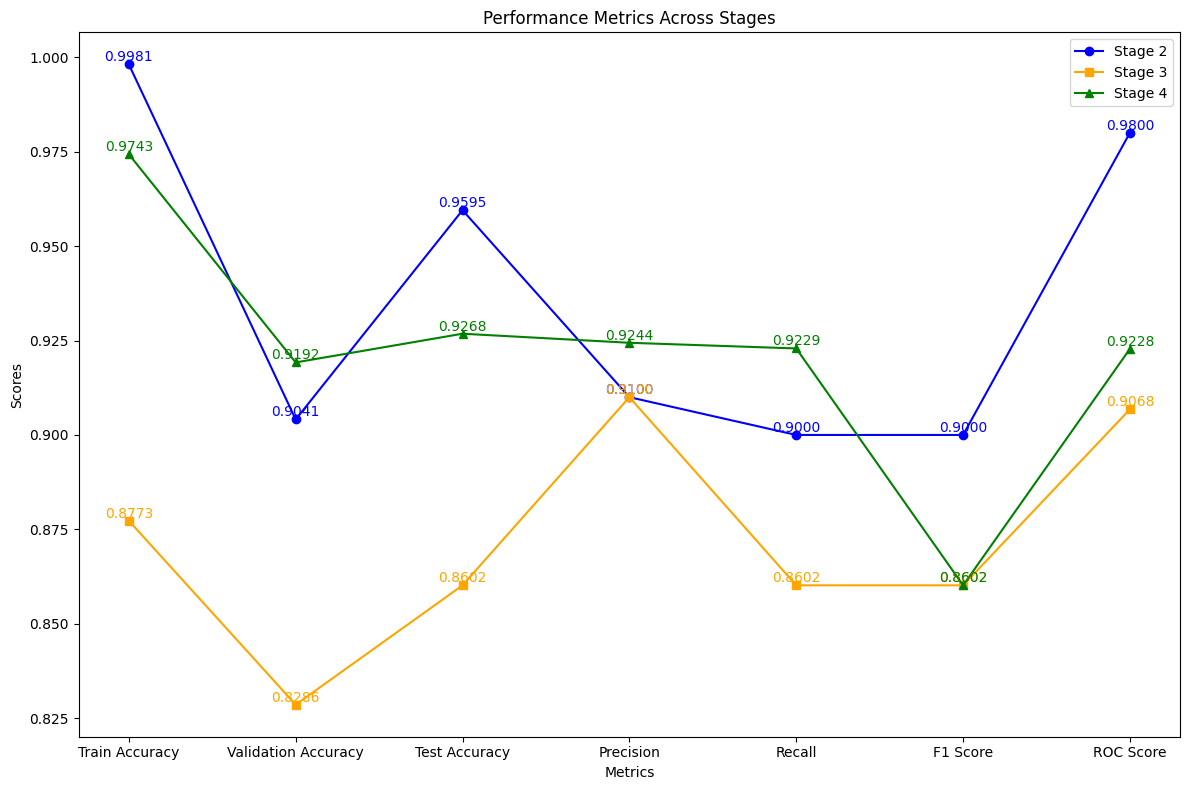

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data
metrics = ['Train Accuracy', 'Validation Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC Score']
stage_2 = [0.9981, 0.9041, 0.9595, 0.91, 0.90, 0.90, 0.98]
stage_3 = [0.8773, 0.8286, 0.8602, 0.91, 0.8602, 0.8602, 0.9068]
stage_4 = [0.9743, 0.9192, 0.9268, 0.9244, 0.9229, 0.8602, 0.9228]

# X-axis labels
x = np.arange(len(metrics))

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the lines
ax.plot(x, stage_2, marker='o', label='Stage 2', color='blue', linestyle='-')
ax.plot(x, stage_3, marker='s', label='Stage 3', color='orange', linestyle='-')
ax.plot(x, stage_4, marker='^', label='Stage 4', color='green', linestyle='-')

# Adding text labels for each point
for i in range(len(metrics)):
    ax.text(x[i], stage_2[i], f'{stage_2[i]:.4f}', ha='center', va='bottom', color='blue')
    ax.text(x[i], stage_3[i], f'{stage_3[i]:.4f}', ha='center', va='bottom', color='orange')
    ax.text(x[i], stage_4[i], f'{stage_4[i]:.4f}', ha='center', va='bottom', color='green')

# Labeling the plot
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics Across Stages')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()
